# 06_benchmark_analysis.ipynb — combine, ROC, CM, McNemar

# Cell 0 — perf env

In [1]:
# (same perf env)
import os
os.environ.setdefault("OMP_NUM_THREADS", "8")
os.environ.setdefault("OPENBLAS_NUM_THREADS", "8")
os.environ.setdefault("MKL_NUM_THREADS", "8")
os.environ.setdefault("NUMEXPR_NUM_THREADS", "8")

'8'

# Cell 1 — imports & load

In [2]:
from pathlib import Path
import json, warnings, numpy as np, pandas as pd, matplotlib.pyplot as plt
import pennylane as qml
from pennylane import numpy as pnp
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import (roc_auc_score, roc_curve, accuracy_score, precision_recall_fscore_support, confusion_matrix, f1_score)

warnings.filterwarnings("ignore")
ROOT = Path("."); PROCESSED = ROOT/"data/processed"; RESULTS = ROOT/"results"
(RESULTS/"metrics").mkdir(parents=True, exist_ok=True); (RESULTS/"stats").mkdir(parents=True, exist_ok=True)

data = np.load(PROCESSED/"encodings.npz", allow_pickle=True)
with open(PROCESSED/"splits.json") as f: SPL = json.load(f)
y = data["y"].astype(int); X_kmer = data["kmer"].astype(np.float32); X_onehot = data["onehot"].astype(np.float32)
tr = np.array(SPL["train"]); va = np.array(SPL["val"]); te = np.array(SPL["test"])

# Cell 2 — metric pack

In [3]:
def pack_metrics(y_true, y_prob, split, model, thr=0.5):
    y_pred = (y_prob >= thr).astype(int)
    acc = accuracy_score(y_true, y_pred)
    prec, rec, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)
    try: auc = roc_auc_score(y_true, y_prob)
    except: auc = float("nan")
    cm = confusion_matrix(y_true, y_pred)
    return dict(model=model, split=split, acc=acc, prec=prec, rec=rec, f1=f1, auc=auc, thr=thr), y_pred, cm

# Cell 3 — Classical baselines

In [4]:
# SVM k-mer
svm_kmer = make_pipeline(StandardScaler(with_mean=True, with_std=True),
                         SVC(C=5.0, kernel="rbf", gamma="scale", probability=True, class_weight="balanced", random_state=0))
svm_kmer.fit(X_kmer[tr], y[tr])
p_tr = svm_kmer.predict_proba(X_kmer[tr])[:,1]; p_va = svm_kmer.predict_proba(X_kmer[va])[:,1]; p_te = svm_kmer.predict_proba(X_kmer[te])[:,1]
thr_k = max([(t, f1_score(y[va], (p_va>=t).astype(int), zero_division=0)) for t in np.linspace(0.1,0.9,33)], key=lambda x:x[1])[0]
m1_tr, y1_tr, cm1_tr = pack_metrics(y[tr], p_tr, "train", "SVM_kmer", thr=thr_k)
m1_va, y1_va, cm1_va = pack_metrics(y[va], p_va, "val",   "SVM_kmer", thr=thr_k)
m1_te, y1_te, cm1_te = pack_metrics(y[te], p_te, "test",  "SVM_kmer", thr=thr_k)

# SVM one-hot
X_flat = X_onehot.reshape(len(X_onehot), -1).astype(np.float32)
svm_1h = make_pipeline(StandardScaler(with_mean=True, with_std=True),
                       SVC(C=2.0, kernel="rbf", gamma="scale", probability=True, class_weight="balanced", random_state=0))
svm_1h.fit(X_flat[tr], y[tr])
q_tr = svm_1h.predict_proba(X_flat[tr])[:,1]; q_va = svm_1h.predict_proba(X_flat[va])[:,1]; q_te = svm_1h.predict_proba(X_flat[te])[:,1]
thr_1h = max([(t, f1_score(y[va], (q_va>=t).astype(int), zero_division=0)) for t in np.linspace(0.1,0.9,33)], key=lambda x:x[1])[0]
m2_tr, y2_tr, cm2_tr = pack_metrics(y[tr], q_tr, "train", "SVM_onehot", thr=thr_1h)
m2_va, y2_va, cm2_va = pack_metrics(y[va], q_va, "val",   "SVM_onehot", thr=thr_1h)
m2_te, y2_te, cm2_te = pack_metrics(y[te], q_te, "test",  "SVM_onehot", thr=thr_1h)

# Cell 4 — QSVM (load kernels or rebuild tiny)

In [5]:
K_trtr_p = RESULTS/"kernels/K_trtr.npy"; K_vatr_p = RESULTS/"kernels/K_vatr.npy"; K_tetr_p = RESULTS/"kernels/K_tetr.npy"
if K_trtr_p.exists() and K_vatr_p.exists() and K_tetr_p.exists():
    K_trtr = np.load(K_trtr_p); K_vatr = np.load(K_vatr_p); K_tetr = np.load(K_tetr_p)
    ytr_sel = y[tr][:K_trtr.shape[0]]
else:
    D = 8; pca = PCA(n_components=D, random_state=23)
    Xtr_p = pca.fit_transform(X_kmer[tr]); Xva_p = pca.transform(X_kmer[va]); Xte_p = pca.transform(X_kmer[te])
    Xtr_p = (np.clip(Xtr_p, -3, 3)/3.0)*np.pi; Xva_p = (np.clip(Xva_p, -3, 3)/3.0)*np.pi; Xte_p = (np.clip(Xte_p, -3, 3)/3.0)*np.pi
    dev = qml.device("default.qubit", wires=D, shots=None)
    def U(x): qml.AngleEmbedding(x, wires=range(D), rotation="Y"); qml.broadcast(qml.CZ, wires=range(D), pattern="ring")
    @qml.qnode(dev) 
    def kcirc(a,b): U(a); qml.adjoint(U)(b); return qml.probs(wires=range(D))[0]
    def gram(A,B): 
        K = np.zeros((len(A), len(B)))
        for i in range(len(A)):
            for j in range(len(B)): K[i,j] = kcirc(A[i], B[j])
        return K
    K_trtr = gram(Xtr_p, Xtr_p); K_vatr = gram(Xva_p, Xtr_p); K_tetr = gram(Xte_p, Xtr_p)
    ytr_sel = y[tr]

clf_q = SVC(C=5.0, kernel="precomputed", probability=True, class_weight="balanced", random_state=0)
clf_q.fit(K_trtr, ytr_sel)
r_tr = clf_q.predict_proba(K_trtr)[:,1]; r_va = clf_q.predict_proba(K_vatr)[:,1]; r_te = clf_q.predict_proba(K_tetr)[:,1]
thr_q = max([(t, f1_score(y[va], (r_va>=t).astype(int), zero_division=0)) for t in np.linspace(0.1,0.9,33)], key=lambda x:x[1])[0]
m3_tr, y3_tr, cm3_tr = pack_metrics(ytr_sel, r_tr, "train", "QSVM_kernel", thr=thr_q)
m3_va, y3_va, cm3_va = pack_metrics(y[va], r_va, "val",   "QSVM_kernel", thr=thr_q)
m3_te, y3_te, cm3_te = pack_metrics(y[te], r_te, "test",  "QSVM_kernel", thr=thr_q)

# Cell 5 — VQC eval (load weights; val-optimal thr)

In [6]:
D = 6
pca = PCA(n_components=D, random_state=11)
X_tr_p = pca.fit_transform(X_kmer[tr]); X_va_p = pca.transform(X_kmer[va]); X_te_p = pca.transform(X_kmer[te])
scaler = StandardScaler(with_mean=True, with_std=True)
Xtr_v = scaler.fit_transform(X_tr_p).astype(np.float32); Xva_v = scaler.transform(X_va_p).astype(np.float32); Xte_v = scaler.transform(X_te_p).astype(np.float32)

W_PATH = RESULTS/"vqc_weights.npy"
if not W_PATH.exists(): raise FileNotFoundError("Run 04_quantum_vqc.ipynb first.")
weights = pnp.array(np.load(W_PATH), requires_grad=False); L = weights.shape[0]

dev = qml.device("default.qubit", wires=D, shots=None)
try:
    BasicEntanglerLayers = qml.BasicEntanglerLayers
except AttributeError:
    from pennylane.templates.layers import BasicEntanglerLayers
def layer(x, w): qml.AngleEmbedding(x, wires=range(D), rotation="Y"); BasicEntanglerLayers(w[None, :], wires=range(D))
@qml.qnode(dev, interface="autograd")
def vqc(x, w):
    for l in range(L): layer(x, w[l])
    return qml.expval(qml.PauliZ(0))

def vqc_probs(X):
    p = []
    for xi in X:
        m = vqc(xi, weights); p.append((1+float(m))/2)
    return np.clip(np.array(p), 1e-6, 1-1e-6)

s_tr = vqc_probs(Xtr_v); s_va = vqc_probs(Xva_v); s_te = vqc_probs(Xte_v)
thr_v = max([(t, f1_score(y[va], (s_va>=t).astype(int), zero_division=0)) for t in np.linspace(0.1,0.9,33)], key=lambda x:x[1])[0]
m4_tr, y4_tr, cm4_tr = pack_metrics(y[tr], s_tr, "train", "VQC", thr=thr_v)
m4_va, y4_va, cm4_va = pack_metrics(y[va], s_va, "val",   "VQC", thr=thr_v)
m4_te, y4_te, cm4_te = pack_metrics(y[te], s_te, "test",  "VQC", thr=thr_v)

# Cell 6 — save combined + ROC/CM caches

In [7]:
df = pd.DataFrame([m1_tr,m1_va,m1_te, m2_tr,m2_va,m2_te, m3_tr,m3_va,m3_te, m4_tr,m4_va,m4_te])
df.to_csv(RESULTS/"metrics/combined.csv", index=False)

ROC_DIR = RESULTS/"roc_cache"; ROC_DIR.mkdir(parents=True, exist_ok=True)
np.save(ROC_DIR/"y_test.npy", y[te])
np.save(ROC_DIR/"probs_svm_kmer.npy", p_te)
np.save(ROC_DIR/"probs_svm_onehot.npy", q_te)
np.save(ROC_DIR/"probs_qsvm_kernel.npy", r_te)
np.save(ROC_DIR/"probs_vqc.npy", s_te)

CM_DIR = RESULTS/"cm_cache"; CM_DIR.mkdir(parents=True, exist_ok=True)
import json as _json
(Path(CM_DIR/"y_true.json")).write_text(_json.dumps(y[te].astype(int).tolist()))
for name, arr, thr in [("svm_kmer", p_te, m1_te["thr"]),
                       ("svm_onehot", q_te, m2_te["thr"]),
                       ("qsvm_kernel", r_te, m3_te["thr"]),
                       ("vqc", s_te, m4_te["thr"])]:
    (Path(CM_DIR)/f"y_pred_{name}.json").write_text(_json.dumps((arr>=thr).astype(int).tolist()))

df[df.split=="test"].sort_values("f1", ascending=False)

,model,split,acc,prec,rec,f1,auc,thr
5,SVM_onehot,test,0.922819,0.922819,1.000000,0.959860,0.756047,0.10
11,VQC,test,0.922819,0.922819,1.000000,0.959860,0.510988,0.10
2,SVM_kmer,test,0.919463,0.922559,0.996364,0.958042,0.774387,0.55
8,QSVM_kernel,test,0.899329,0.929825,0.963636,0.946429,0.787510,0.70


# Cell 7 — ROC plot

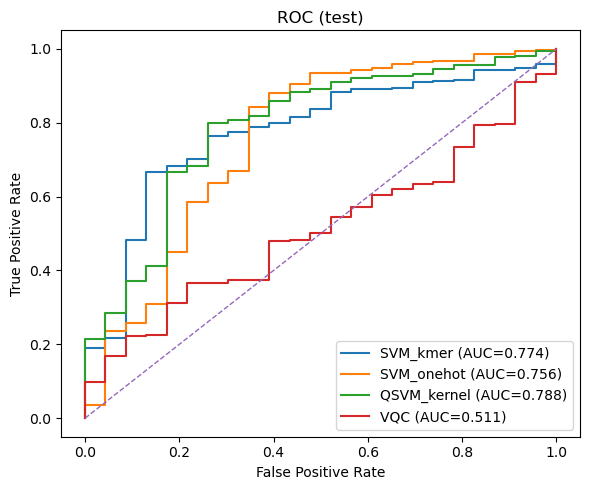

In [8]:
fig, ax = plt.subplots(figsize=(6,5))
def plot_roc(y_true, y_prob, label):
    fpr, tpr, _ = roc_curve(y_true, y_prob); auc = roc_auc_score(y_true, y_prob)
    ax.plot(fpr, tpr, label=f"{label} (AUC={auc:.3f})")
plot_roc(y[te], p_te, "SVM_kmer")
plot_roc(y[te], q_te, "SVM_onehot")
plot_roc(y[te], r_te, "QSVM_kernel")
plot_roc(y[te], s_te, "VQC")
ax.plot([0,1], [0,1], "--", lw=1); ax.set_xlabel("False Positive Rate"); ax.set_ylabel("True Positive Rate"); ax.set_title("ROC (test)"); ax.legend()
plt.tight_layout(); plt.show()

# Cell 8 — confusion matrices

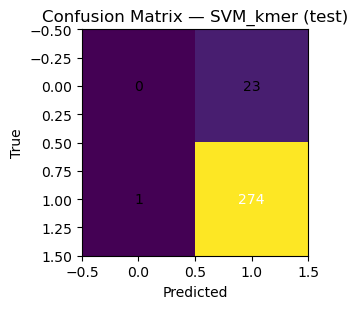

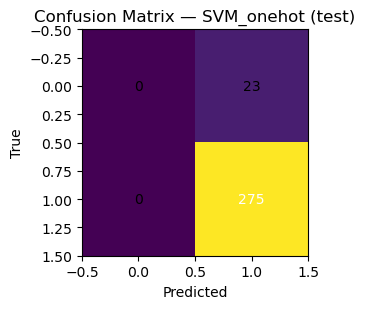

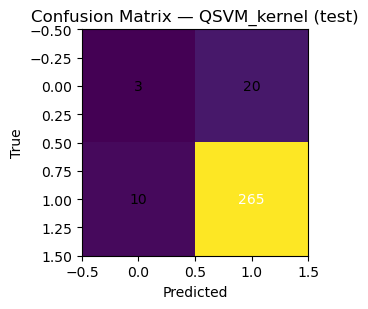

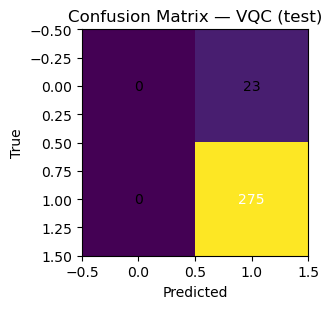

In [9]:
cms = [("SVM_kmer", cm1_te), ("SVM_onehot", cm2_te), ("QSVM_kernel", cm3_te), ("VQC", cm4_te)]
for name, cm in cms:
    fig, ax = plt.subplots(figsize=(3.5,3.2))
    im = ax.imshow(cm, interpolation="nearest")
    ax.set_title(f"Confusion Matrix — {name} (test)")
    ax.set_xlabel("Predicted"); ax.set_ylabel("True")
    for (i,j), v in np.ndenumerate(cm):
        ax.text(j, i, int(v), ha="center", va="center", color="white" if im.norm(v) > 0.5 else "black")
    plt.tight_layout(); plt.show()

# Cell 9 — McNemar tests

In [10]:
from math import fabs, exp
def mcnemar(y_true, yhat_a, yhat_b):
    n01 = int(((yhat_a == y_true) & (yhat_b != y_true)).sum())
    n10 = int(((yhat_a != y_true) & (yhat_b == y_true)).sum())
    chi2 = (fabs(n01 - n10) - 1)**2 / (n01 + n10 + 1e-12)
    p = exp(-chi2/2)
    return {"n01":n01, "n10":n10, "chi2":chi2, "p_approx":p}

stats = {
    "QSVM_vs_SVMkmer": mcnemar(y[te], (p_te>=m1_te["thr"]).astype(int), (r_te>=m3_te["thr"]).astype(int)),
    "VQC_vs_SVMkmer":  mcnemar(y[te], (p_te>=m1_te["thr"]).astype(int), (s_te>=m4_te["thr"]).astype(int)),
    "SVM1hot_vs_SVMkmer": mcnemar(y[te], (p_te>=m1_te["thr"]).astype(int), (q_te>=m2_te["thr"]).astype(int)),
}
with open(RESULTS/"stats/mcnemar.json","w") as f: json.dump(stats, f, indent=2)
stats

{'QSVM_vs_SVMkmer': {'n01': 10,
  'n10': 4,
  'chi2': 1.7857142857141581,
  'p_approx': 0.40948412515239035},
 'VQC_vs_SVMkmer': {'n01': 0, 'n10': 1, 'chi2': 0.0, 'p_approx': 1.0},
 'SVM1hot_vs_SVMkmer': {'n01': 0, 'n10': 1, 'chi2': 0.0, 'p_approx': 1.0}}